In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd

In [2]:
def svd(X, k=None):
    if k is None:
        k = min(*X.shape)
    U, s, Vh = np.linalg.svd(X, full_matrices=False)
    return U[:, :k] * s[:k] @ Vh[:k]

def rsvd(X, k=None, random_state=None):
    # https://scikit-learn.org/dev/modules/generated/sklearn.utils.extmath.randomized_svd.html
    # https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.TruncatedSVD.html
    if k is None:
        k = min(*X.shape)
    U, s, Vh = randomized_svd(X, k, random_state=random_state, n_oversamples=0, n_iter=0) # last two params speed-accuracy tradeoff
    return U * s @ Vh

In [3]:
def rank_experiment(X, func, ranks, n_trials: int = 5):
    to = []
    eo = []
    
    for k in ranks:
        ti = []
        ei = []
        
        for trial in range(n_trials):
            t0 = time.perf_counter()
            er = np.linalg.norm(X - func(X, k))
            t1 = time.perf_counter()

            ti.append(t1 - t0)
            ei.append(er)
        
        to.append(ti)
        eo.append(ei)

    to = np.array(to)
    eo = np.array(eo)
    
    metrics = {}
    metrics["rank"] = ranks
    metrics["time_avg"] = to.mean(axis=1)
    metrics["time_std"] = to.var(axis=1)
    metrics["error_avg"] = eo.mean(axis=1)
    metrics["error_std"] = eo.var(axis=1)
    
    return metrics

## Experiment 1: Low-rank approximation of a fixed matrix

In [4]:
%%time

# Run experiment over many ranks
np.random.seed(42)

ranks = np.linspace(100, 1000, num=10, dtype=int) # NOTE: This is small for testing purposes, real deal should be at least 2 order magnitude greater
n = ranks[-1]
X = np.random.normal(0, 1, (n, n))
n_trials = 10

svd_metrics = {}
svd_metrics["name"] = ["svd"] * len(ranks)
func = lambda x, k: svd(x, k)
svd_metrics = {**svd_metrics, **rank_experiment(X, func, ranks, n_trials)}

rsvd_metrics = {}
rsvd_metrics["name"] = ["rsvd"] * len(ranks)
func = lambda x, k: rsvd(x, k)
rsvd_metrics = {**rsvd_metrics, **rank_experiment(X, func, ranks, n_trials)}

CPU times: user 43.1 s, sys: 7.25 s, total: 50.4 s
Wall time: 31.9 s


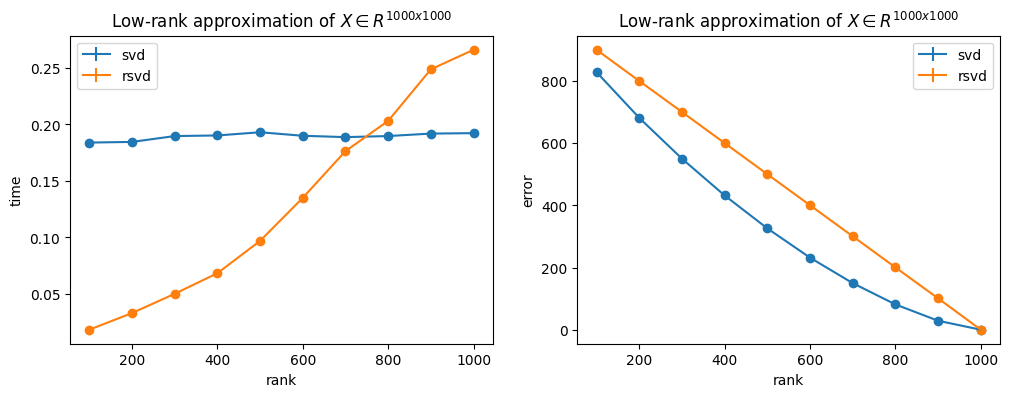

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

measures = ["time", "error"]
for i, measure in enumerate(measures):
    
    metrics = svd_metrics
    ax[i].errorbar(ranks, metrics[f"{measure}_avg"], metrics[f"{measure}_std"], label="svd")
    ax[i].scatter(ranks, metrics[f"{measure}_avg"])

    metrics = rsvd_metrics
    ax[i].errorbar(ranks, metrics[f"{measure}_avg"], metrics[f"{measure}_std"], label="rsvd")
    ax[i].scatter(ranks, metrics[f"{measure}_avg"])

    ax[i].set_title(f"Low-rank approximation of $X \\in R^{{{n}x{n}}}$")
    ax[i].set_xlabel("rank")
    ax[i].set_ylabel(measure)
    ax[i].legend()
    
plt.show()

In [6]:
df = pd.DataFrame([svd_metrics, rsvd_metrics])
df = df.explode(df.columns.tolist())
df

,name,rank,time_avg,time_std,error_avg,error_std
0,svd,100,0.183914,0.000001,828.336423,0.0
0,svd,200,0.184497,0.000004,681.318158,0.0
0,svd,300,0.189675,0.000043,550.10497,0.0
0,svd,400,0.190209,0.000017,431.755695,0.0
0,svd,500,0.193052,0.000072,325.941131,0.0
0,svd,600,0.189942,0.000022,231.696034,0.0
0,svd,700,0.188741,0.000001,149.789119,0.0
0,svd,800,0.189698,0.000002,81.375658,0.0
0,svd,900,0.191871,0.000002,28.824422,0.0
0,svd,1000,0.192255,0.000001,0.0,0.0


## Experiment 2: Low-rank approximation of different matrix scales

In [7]:
# Run experiment over many sizes
np.random.seed(42)

# Xs = [
#     np.random.normal(0, 1, (n, n)),
#     np.random.normal(0, 1, (n, n)),
#     ...
#     np.random.normal(0, 1, (n, n)),
# ]

## Experiment 3: rSVD Hyperparameters

In [8]:
# Experiments demonstrating impact of parameters on runtime and accuracy
# Requires reviewing https://arxiv.org/abs/0909.4061
# above is theoretical justification
# and https://github.com/scikit-learn/scikit-learn/blob/6bf2061f7/sklearn/utils/extmath.py#L524C3-L530C6
# above is basically the meat of the implementation